In [1]:
import pickle
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm

from backtester.options import Option, OptionChain, Loader
from backtester.strategy import Leg, Strategy


In [2]:
%load_ext autoreload
%autoreload 2

# HMM Model

## Training

In [459]:
train = yf.Ticker("GOOGL").history(start="2001-01-01", end="2017-12-31")['Close'].to_frame().pct_change().dropna()
test = yf.Ticker("GOOGL").history(start="2018-01-01", end="2020-12-31")['Close'].to_frame().pct_change().dropna()

model = hmm.GaussianHMM(n_components=2, n_iter=100, covariance_type="full")
model.fit(train)
test_res = model.predict_proba(test)

test_res = test_res[:,1]
#test_res = np.where(np.expand_dims(test_res, 0) < 0.9, 1, 0)

regime = yf.Ticker("GOOGL").history(start="2018-01-01", end="2020-12-31")['Close'][1:].to_frame()
regime['regime'] = test_res.flatten()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

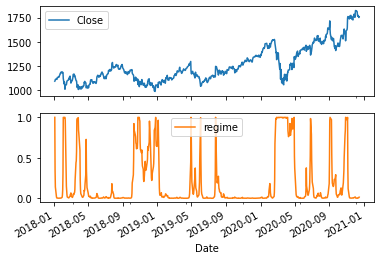

In [460]:
regime.plot(subplots=True)

In [1017]:
pickle.dump(model, open( "./models/goog_hmm.pkl", "wb" ) )

In [7]:
def load_regime(model_file, ticker, start, end, today:tuple = None, col=0): #today(date: str[yyyy-mm-dd], price)
    model = pickle.load(open(model_file,"rb"))
    
    price = yf.Ticker(ticker).history(start=start, end=end)['Close'].to_frame()
    
    if today:
        today = pd.DataFrame([today[1]], index=[np.datetime64(today[0])], columns=['Close'])
        price = price.append(today)
    
    data = price.pct_change().dropna()
    
    regime = np.zeros(len(data))
    
    for idx in range(len(data)):
        regime[idx] = model.predict_proba(data.iloc[0:idx + 1])[-1,col]
    
    
    price = price[1:]
    price['regime'] = regime
    return price

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

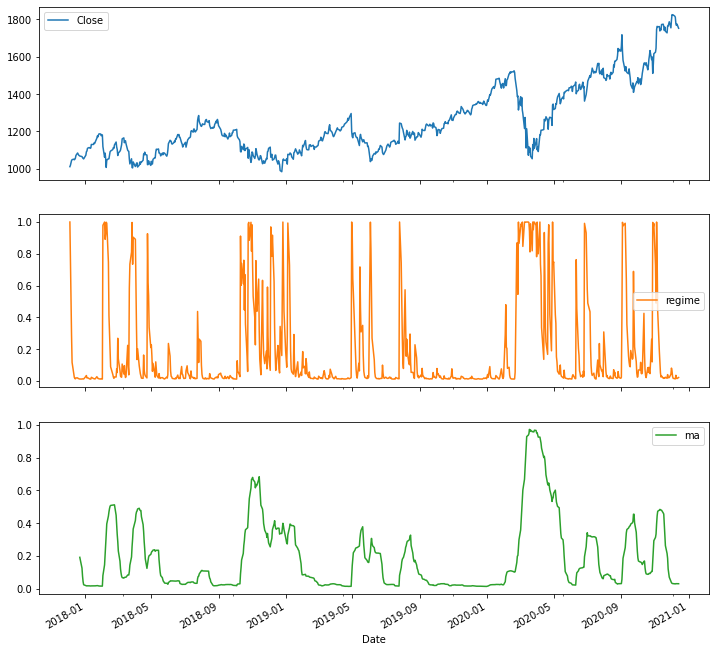

In [155]:
googl_regime = load_regime('./models/googl_hmm.pkl', "GOOGL", "2017-12-01", "2020-12-15", col=1)
googl_regime['ma'] = googl_regime['regime'].rolling(15).mean()
googl_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

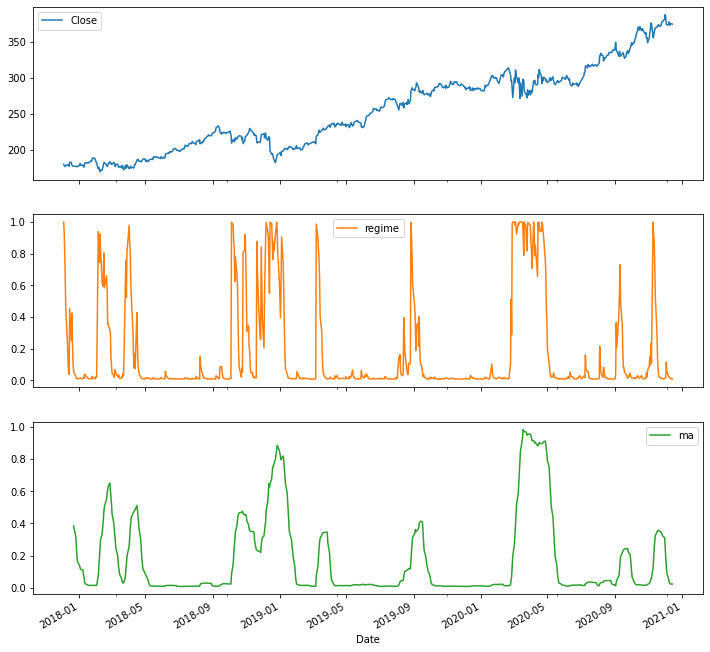

In [157]:
cost_regime = load_regime('./models/cost_hmm.pkl', "COST", "2017-12-01", "2020-12-15", col=1)
cost_regime['ma'] = cost_regime['regime'].rolling(15).mean()
cost_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

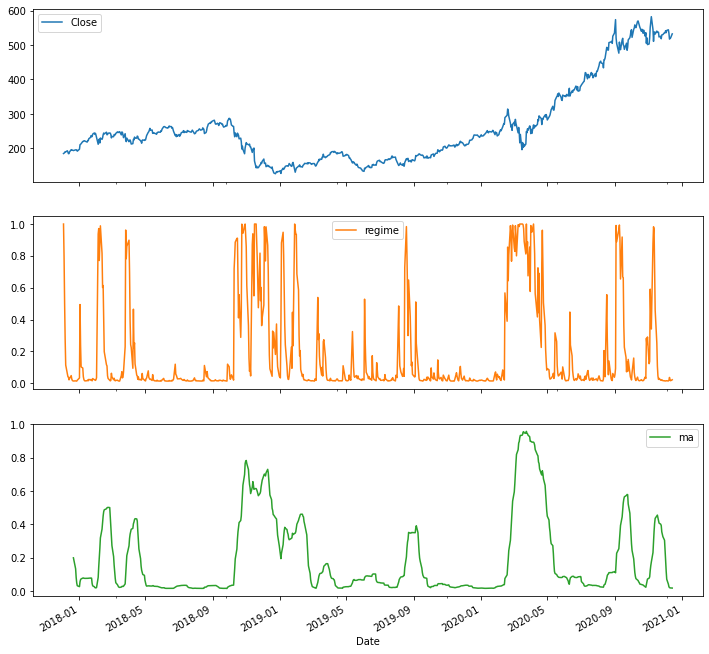

In [158]:
nvda_regime = load_regime('./models/nvda_hmm.pkl', "NVDA", "2017-12-01", "2020-12-15", col=1)
nvda_regime['ma'] = nvda_regime['regime'].rolling(15).mean()
nvda_regime.plot(subplots=True, figsize=(12,12))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

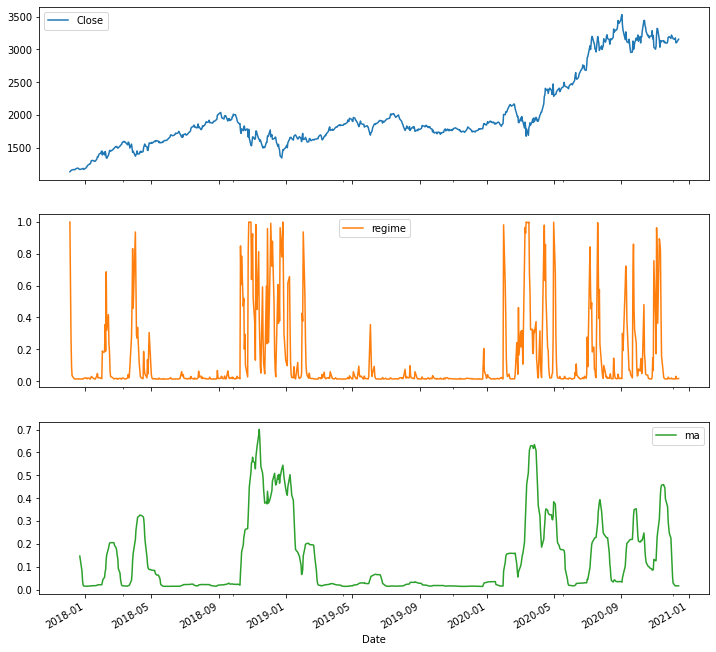

In [160]:
amzn_regime = load_regime('./models/amzn_hmm.pkl', "AMZN", "2017-12-01", "2020-12-15", col=0)
amzn_regime['ma'] = amzn_regime['regime'].rolling(15).mean()
amzn_regime.plot(subplots=True, figsize=(12,12))

In [161]:
def googl_decider(date):
    if googl_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def cost_decider(date):
    if cost_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def nvda_decider(date):
    if nvda_regime.loc[date]['ma'] > 0.4:
        return False

    return True

def amzn_decider(date):
    if amzn_regime.loc[date]['ma'] > 0.4:
        return False

    return True

In [602]:
def decider_short(date):
    if regime.loc[date]['regime'] > 0.9:
        return True

    return False

In [56]:
decider(np.datetime64('2018-01-24'))

True

# Option Strat Backtest

In [153]:
data_paths = [f"./data/{f}" for f in listdir('./data') if isfile(join('./data', f))]

In [154]:
# load data
loader = Loader()
loader.load_data(data_paths, True)

In [244]:
leg_1 = Leg(loader, np.datetime64('2018-01-05'))
leg_1.ticker = "COST"
leg_1.side = 's'
leg_1.quantity = 20
leg_1.opt_type = 'put'
leg_1.tenor_day = 7
leg_1.moneyness = 0.98
leg_1.open_frequency_d = 'roll'
leg_1.close_n_tday_before = 0
leg_1.open_px = 'mid'
leg_1.close_px = 'bid'
leg_1.decider = cost_decider

leg_2 = Leg(loader, np.datetime64('2018-01-05'))
leg_2.ticker = "COST"
leg_2.side = 'l'
leg_2.quantity = 20
leg_2.opt_type = 'put'
leg_2.tenor_day = 30
leg_2.moneyness = 0.90
leg_2.open_frequency_d = 7
leg_2.close_n_tday_before = 15
leg_2.open_px = 'mid'
leg_2.close_px = 'mid'
leg_2.decider = cost_decider


leg_3 = Leg(loader, np.datetime64('2018-01-05'))
leg_3.ticker = "GOOGL"
leg_3.side = 's'
leg_3.quantity = 3
leg_3.opt_type = 'put'
leg_3.tenor_day = 7
leg_3.moneyness = 0.98
leg_3.open_frequency_d = 'roll'
leg_3.close_n_tday_before = 0
leg_3.open_px = 'mid'
leg_3.close_px = 'bid'
leg_3.decider = googl_decider

leg_4 = Leg(loader, np.datetime64('2018-01-05'))
leg_4.ticker = "GOOGL"
leg_4.side = 'l'
leg_4.quantity = 3
leg_4.opt_type = 'put'
leg_4.tenor_day = 30
leg_4.moneyness = 0.90
leg_4.open_frequency_d = 7
leg_4.close_n_tday_before = 15
leg_4.open_px = 'mid'
leg_4.close_px = 'mid'
leg_4.decider = googl_decider

leg_5 = Leg(loader, np.datetime64('2018-01-05'))
leg_5.ticker = "NVDA"
leg_5.side = 's'
leg_5.quantity = 17
leg_5.opt_type = 'put'
leg_5.tenor_day = 7
leg_5.moneyness = 0.98
leg_5.open_frequency_d = 'roll'
leg_5.close_n_tday_before = 0
leg_5.open_px = 'mid'
leg_5.close_px = 'bid'
leg_5.decider = nvda_decider

leg_6 = Leg(loader, np.datetime64('2018-01-05'))
leg_6.ticker = "NVDA"
leg_6.side = 'l'
leg_6.quantity = 17
leg_6.opt_type = 'put'
leg_6.tenor_day = 30
leg_6.moneyness = 0.90
leg_6.open_frequency_d = 7
leg_6.close_n_tday_before = 15
leg_6.open_px = 'mid'
leg_6.close_px = 'mid'
leg_6.decider = nvda_decider

leg_7 = Leg(loader, np.datetime64('2018-01-05'))
leg_7.ticker = "AMZN"
leg_7.side = 's'
leg_7.quantity = 3
leg_7.opt_type = 'put'
leg_7.tenor_day = 7
leg_7.moneyness = 0.98
leg_7.open_frequency_d = 'roll'
leg_7.close_n_tday_before = 0
leg_7.open_px = 'mid'
leg_7.close_px = 'bid'
leg_7.decider = amzn_decider

leg_8 = Leg(loader, np.datetime64('2018-01-05'))
leg_8.ticker = "AMZN"
leg_8.side = 'l'
leg_8.quantity = 3
leg_8.opt_type = 'put'
leg_8.tenor_day = 30
leg_8.moneyness = 0.90
leg_8.open_frequency_d = 7
leg_8.close_n_tday_before = 15
leg_8.open_px = 'mid'
leg_8.close_px = 'mid'
leg_8.decider = amzn_decider


In [245]:
strategy = Strategy([leg_1,leg_2, leg_3,leg_4, leg_5,leg_6,leg_7,leg_8])
df = strategy.get_stats()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

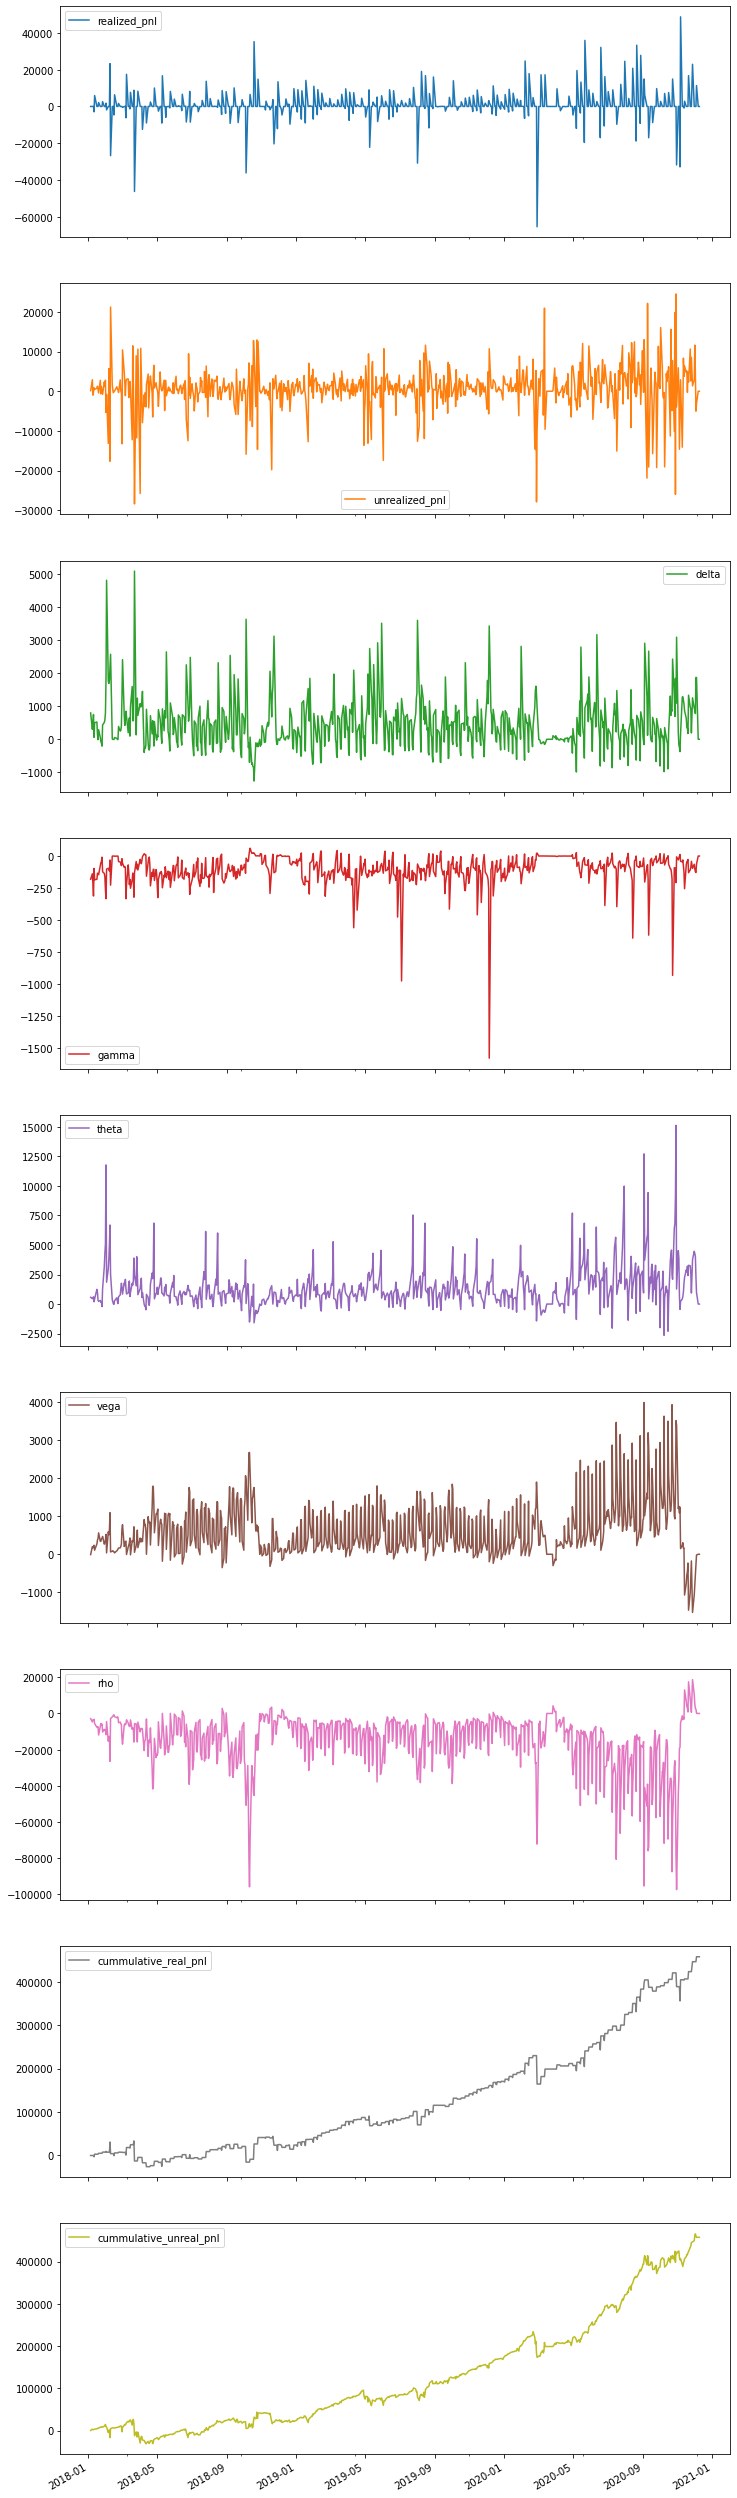

In [247]:
df.plot(subplots=True, figsize=(12, 50))

In [187]:
leg_2.dates[leg_2.check_date(np.datetime64('2018-03-16')) - 15]

numpy.datetime64('2018-02-23')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

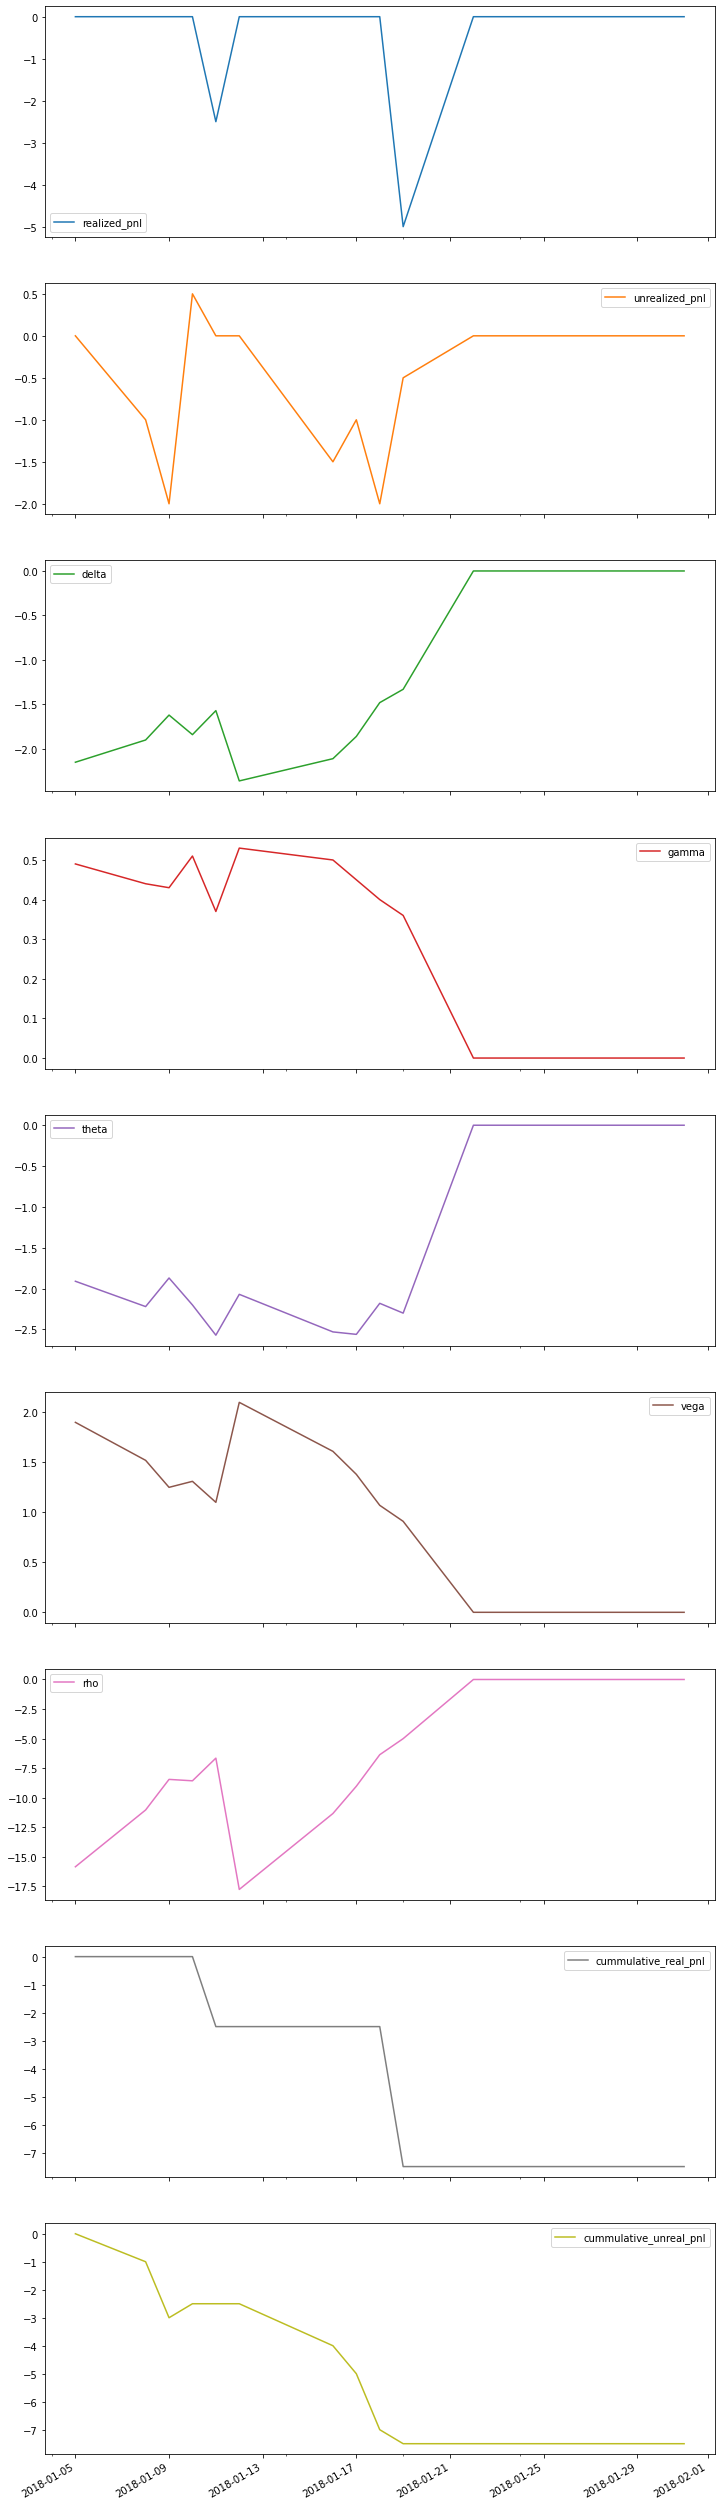

In [1313]:
df1 = pd.DataFrame()

In [1314]:
df1['hmm'] = df['cummulative_unreal_pnl']

In [1321]:
df1['no_hmm'] = df['cummulative_unreal_pnl']

<AxesSubplot:>

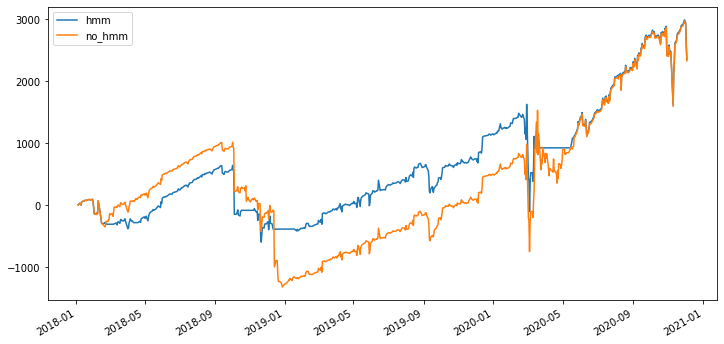

In [1322]:
df1.plot(figsize=(12,6))

In [248]:
df_2 = df.copy()

In [249]:
df_2.to_csv('./port_hmm.csv')

In [749]:
test

,first,second
0.15,111,NaN


In [750]:
test.loc[0.15] = {'second': 222}

In [753]:
test.loc[0.2, 'first'] = 5

In [754]:
test

,first,second
0.15,NaN,222
0.20,5,NaN


In [ ]:
test.append([], ignore_index=True)

In [762]:
from backtester.surface import Volatility

In [763]:
surf = Volatility(loader)

In [782]:
surf.get_vol_surface("GOOGL", np.datetime64('2019-10-02'), "put", [7, 14], "moneyness")

,7,14
0.796441,0.5979,0.4726
0.804914,0.5731,0.4676
0.813387,0.5484,0.4375
0.821860,0.5301,0.4249
0.830333,0.5055,0.4115
...,...,...
1.491209,NaN,0.8895
1.508155,NaN,0.9075
1.525101,NaN,0.9205
1.542046,NaN,0.942


In [1332]:
surface = surf.get_vol_surface("GOOGL", np.datetime64('2020-01-28'), [7, 23, 60, 90], "moneyness")


In [1333]:
surface =surface.reset_index()

In [1334]:
surface = surface.sort_values(by=['index'])

Text(0.5, 1.0, '2020-12-08 Vol Surface')

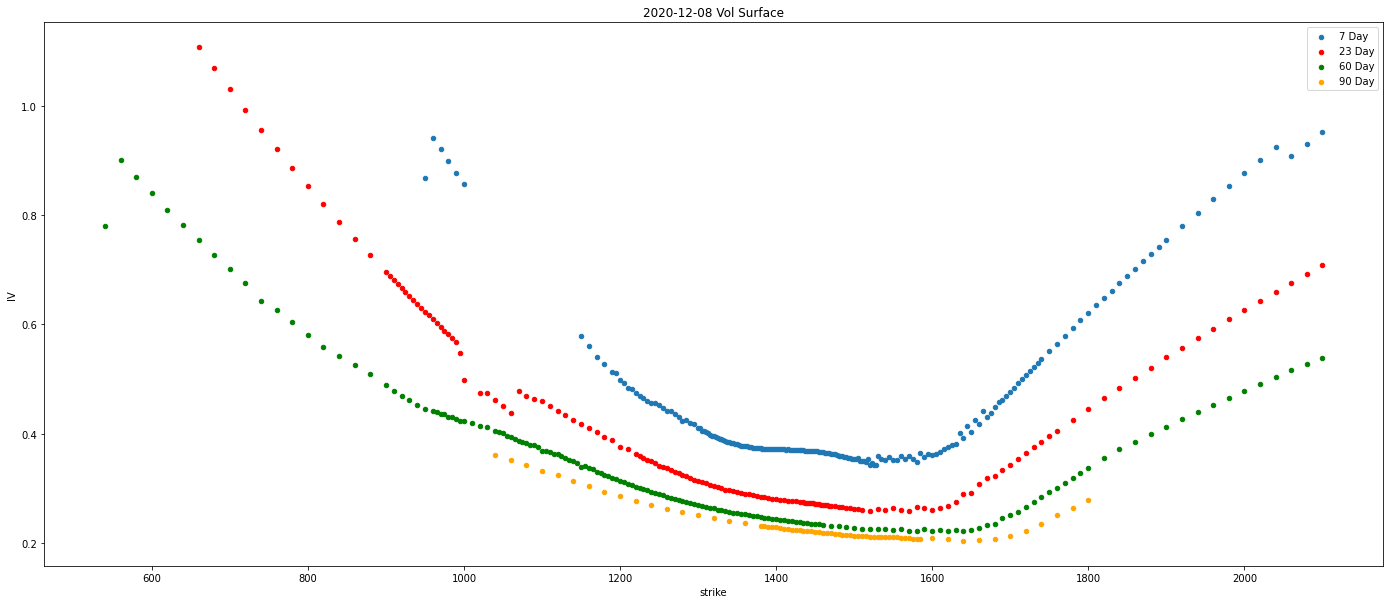

In [1336]:
ax = surface.plot.scatter(x='index', y=7, label="7 Day", figsize=(24,10))
surface.plot.scatter(x='index', y=23, color='red', label="23 Day", ax=ax)
surface.plot.scatter(x='index', y=60, color='green', label="60 Day", ax=ax)
surface.plot.scatter(x='index', y=90, color='orange', label="90 Day", ax=ax)

ax.set_xlabel("strike")
ax.set_ylabel("IV")
ax.set_title("2020-12-08 Vol Surface")

In [847]:
surface['test']

KeyError: 'test'

In [774]:
t_d = {"foo": [2, 5, 8]}

In [779]:
t_d.values()


dict_values([[2, 5, 8]])